<a href="https://colab.research.google.com/github/VoKisnaHai1102/DreamDiffusion/blob/main/240563_KrishnaAg_week2fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
!pip install mne
import mne
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.fft import rfft, rfftfreq

In [17]:
def create_mne_raw_object(signal_tensor, sampling_rate=128):
    signal_array = signal_tensor.numpy().astype(np.float32)
    if signal_array.shape[0] > signal_array.shape[1]:
        signal_array = signal_array.T

    channel_labels = [f"EEG {idx}" for idx in range(signal_array.shape[0])]
    channel_categories = ["eeg"] * len(channel_labels)
    mne_info = mne.create_info(ch_names=channel_labels, sfreq=sampling_rate, ch_types=channel_categories)

    raw_object = mne.io.RawArray(signal_array, mne_info, verbose=False)
    raw_object.filter(5, 45, fir_design='firwin', verbose=False)
    raw_object.set_eeg_reference('average', verbose=False)
    return raw_object

def create_normalized_epochs(raw_object):
    """Segment data into epochs and apply normalization"""
    epoch_data = mne.make_fixed_length_epochs(raw_object, duration=1.0, preload=True, verbose=False)
    extracted_data = epoch_data.get_data()

    normalized_data = (extracted_data - extracted_data.mean(axis=2, keepdims=True)) / extracted_data.std(axis=2, keepdims=True)
    return normalized_data


In [18]:
def expand_channels_to_target(signal_data, target_channels=128):
    """Expand or truncate channels to target number"""
    num_epochs, current_channels, time_points = signal_data.shape

    if current_channels < target_channels:

        repetition_count = int(np.ceil(target_channels / current_channels))
        expanded_data = np.tile(signal_data, (1, repetition_count, 1))[:, :target_channels, :]
    else:
        expanded_data = signal_data[:, :target_channels, :]

    return expanded_data

def create_temporal_tokens(signal_data, token_length=4):
    num_epochs, num_channels, time_samples = signal_data.shape
    assert time_samples % token_length == 0

    new_time_dim = time_samples // token_length
    reshaped_data = signal_data.reshape(num_epochs, num_channels, new_time_dim, token_length)
    token_data = reshaped_data.transpose(0, 2, 1, 3).reshape(num_epochs, new_time_dim, -1)
    return token_data

In [19]:
class SignalEmbeddingLayer(nn.Module):
    """Neural network layer for embedding EEG tokens"""
    def __init__(self, input_features, embedding_size=1024):
        super().__init__()
        self.projection_layer = nn.Linear(input_features, embedding_size)

    def forward(self, input_tokens):

        return self.projection_layer(input_tokens)

In [20]:
def compute_power_spectrum(signal_data, sampling_rate=128):
    """Compute FFT power spectrum"""
    fft_coefficients = np.fft.rfft(signal_data, axis=-1)
    power_spectrum = np.abs(fft_coefficients) ** 2
    frequency_bins = np.fft.rfftfreq(signal_data.shape[-1], d=1/sampling_rate)
    return power_spectrum, frequency_bins

def visualize_power_spectrum(power_data, freq_bins, epoch_idx=1, channel_idx=1):
    """Plot power spectrum for specific epoch and channel"""
    plt.figure(figsize=(10, 6))
    plt.plot(freq_bins, power_data[epoch_idx, channel_idx])
    plt.title(f"Power Spectrum (Epoch {epoch_idx}, Channel {channel_idx})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.show()

def create_spectrogram_plot(signal_data, sampling_rate=128, selected_channel=0):
    """Generate spectrogram visualization"""
    channel_signal = signal_data[selected_channel]

    plt.figure(figsize=(10, 4))
    plt.specgram(channel_signal, NFFT=256, Fs=sampling_rate, noverlap=128, cmap='magma')
    plt.title("Spectrogram Visualization")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label='Intensity [dB]')
    plt.tight_layout()
    plt.show()

def analyze_frequency_evolution(signal_data, sampling_rate=128, selected_channel=0):
    """Plot frequency evolution over time"""
    num_epochs = signal_data.shape[0]
    time_points = np.arange(num_epochs)

    frequency_evolution = []
    for epoch_data in signal_data:
        channel_signal = epoch_data[selected_channel]
        freq_bins = rfftfreq(len(channel_signal), d=1/sampling_rate)
        fft_amplitudes = np.abs(rfft(channel_signal))

        mean_frequency = np.sum(freq_bins * fft_amplitudes) / np.sum(fft_amplitudes)
        frequency_evolution.append(mean_frequency)

    plt.figure(figsize=(10, 4))
    plt.plot(time_points, frequency_evolution, marker='o')
    plt.title("Frequency Evolution Over Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [21]:
dataset_path = '/content/drive/MyDrive/EEG DATA/eeg_signals_raw_with_mean_std.pth'
loaded_data = torch.load(dataset_path)

print(type(loaded_data['dataset'][0]))
print(loaded_data['dataset'][0])

data = loaded_data['dataset']

<class 'dict'>
{'eeg': tensor([[    0,     0,     2,  ...,   -37,   -39,   -38],
        [  -12,   -11,    -8,  ...,   -26,   -30,   -33],
        [   35,    29,    21,  ...,   -17,   -12,    -9],
        ...,
        [ -830,  -826,  -838,  ...,  -935,  -956, -1028],
        [ -782,  -848,  -840,  ...,  -951,  -987,  -994],
        [-2656, -2643, -2616,  ..., -2747, -2779, -2786]], dtype=torch.int16), 'image': 0, 'label': 10, 'subject': 4}


In [10]:
print(type(data_dict['dataset'][0]))
print(data_dict['dataset'][0])
data= data_dict['dataset']
for sample in data:
    eeg_tensor = sample['eeg']
    raw = preprocess_with_mne(eeg_tensor)
    epochs = segment_and_normalize(raw)
    padded = pad_channels_to_128(epochs)
    tokens = temporal_tokenize(padded)

    embedder = EEGEmbedder(input_dim=tokens.shape[-1])
    embedded_tokens = embedder(torch.tensor(tokens).float())


<class 'dict'>
{'eeg': tensor([[    0,     0,     2,  ...,   -37,   -39,   -38],
        [  -12,   -11,    -8,  ...,   -26,   -30,   -33],
        [   35,    29,    21,  ...,   -17,   -12,    -9],
        ...,
        [ -830,  -826,  -838,  ...,  -935,  -956, -1028],
        [ -782,  -848,  -840,  ...,  -951,  -987,  -994],
        [-2656, -2643, -2616,  ..., -2747, -2779, -2786]], dtype=torch.int16), 'image': 0, 'label': 10, 'subject': 4}


<ipython-input-20-8314bacc6d1f>:23: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  plt.specgram(channel_signal, NFFT=256, Fs=sampling_rate, noverlap=128, cmap='magma')


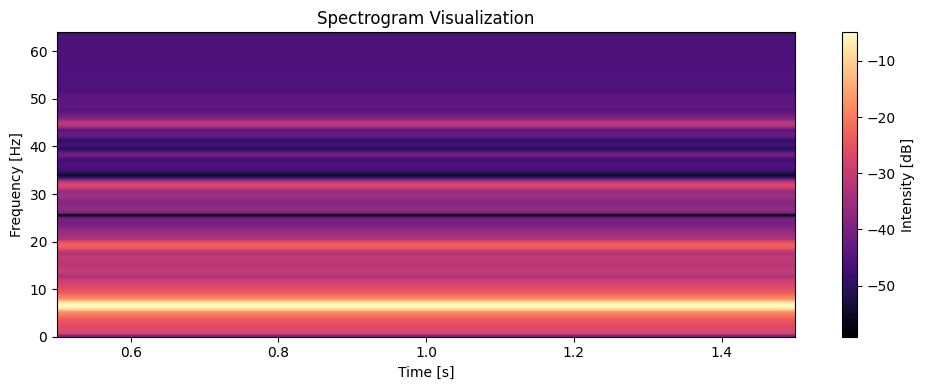

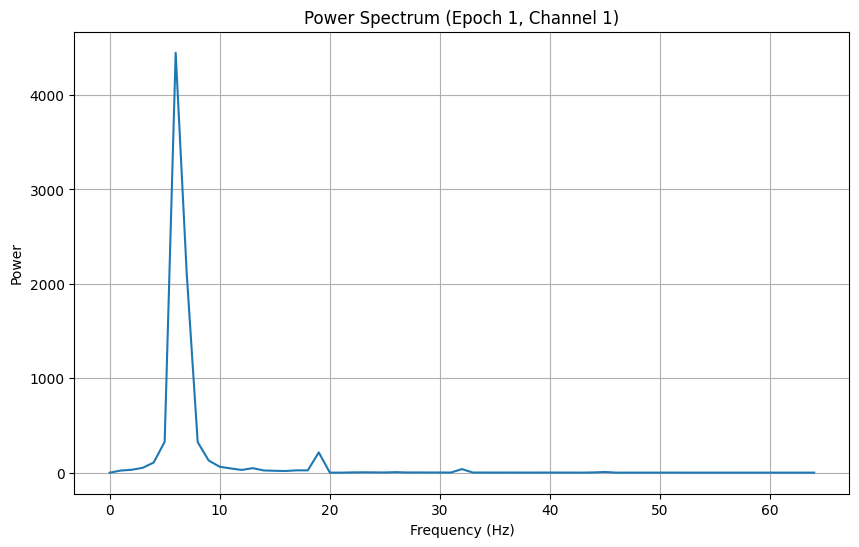

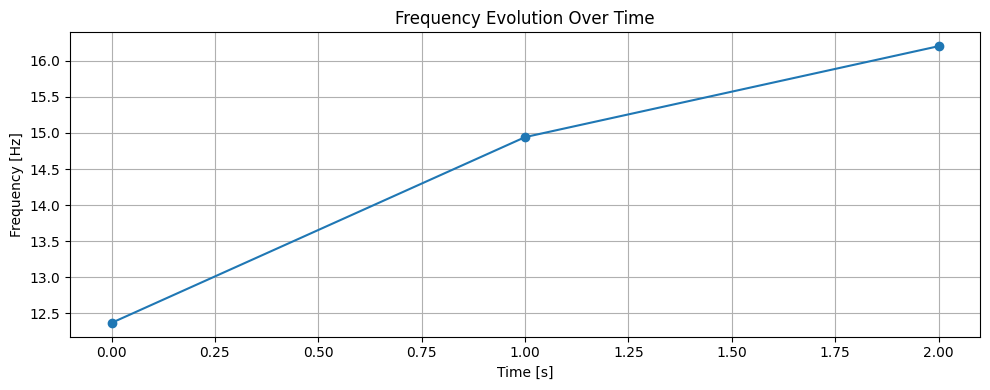

In [22]:
create_spectrogram_plot(padded[0], selected_channel=0)
power_data, freq_bins = compute_power_spectrum(padded)
visualize_power_spectrum(power_data, freq_bins)
analyze_frequency_evolution(padded)